# Model Learning experiment

This notebook reproduces the Option Learning experiment from the STOMP paper.

As in the implementation from the paper, the TwoRooms environment has 72 states, the 72 non-terminal grid cells.

In [1]:
""" Imports """
import numpy as np

from gridworld.gridworld import TemporaryGridWorld as GridWorld
from gridworld.room_design import stomp_two_room_design
from stomp.framework import TemporarySTOMP as STOMP


In [2]:
%load_ext autoreload
%autoreload 1
%aimport gridworld.gridworld
%aimport stomp.framework
%aimport stomp.steps.model_learning

In [3]:
""" Experiment Parameters """

runs = 100
number_of_steps = 50000
subgoal_state_idx = 30  # this is the hallway state in the TwoRooms
subgoal_idx = 0  # we are learning only one option in this example

env = GridWorld(room_array=stomp_two_room_design)

env.num_states


72

In [4]:
""" Learn option """
state = env.reset()
state_features = env.get_one_hot_state(state)
initial_state_features = state_features

_stomp = STOMP(
    env=env,
    subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
)

# Local access to option learning
option_learning = _stomp.option_learning

initial_state_estimative, rmse_of_states = option_learning.learn_options(
    subgoal_idx, number_of_steps, return_rmse=True
)

# Get learned option value function and policy
option_w = _stomp.stomp_foundation.w_subgoal[subgoal_idx]
option_theta = _stomp.stomp_foundation.theta_subgoal[subgoal_idx]

# Check if the learned option value function is close to the expected value
import math
assert math.isclose(option_w @ initial_state_features, 0.831, rel_tol=0.05)

100%|██████████| 50000/50000 [00:19<00:00, 2604.95it/s]


In [5]:
""" Check learned parameters """

assert option_w is not None
assert option_theta is not None


In [6]:
""" Run Experiment """

# Store statistics
many_reward_model_rmses = np.zeros((runs, number_of_steps))
many_transition_model_errors = np.zeros((runs, number_of_steps))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Initialize option with previously learned parameters
    stomp.stomp_foundation.w_subgoal[subgoal_idx] = option_w
    stomp.stomp_foundation.theta_subgoal[subgoal_idx] = option_theta

    # Local access to model learning
    model_learning = stomp.model_learning

    # Only one option besides the primitive actions
    option_idx = stomp.stomp_foundation.env.num_actions

    reward_model_rmses, transition_model_errors = model_learning.learn_model(
        option_idx, number_of_steps
    )

    # Store results
    many_reward_model_rmses[i] = reward_model_rmses
    many_transition_model_errors[i] = transition_model_errors


Run 1/100


100%|██████████| 50000/50000 [01:43<00:00, 483.19it/s]


Run 2/100


100%|██████████| 50000/50000 [01:43<00:00, 483.53it/s]


Run 3/100


100%|██████████| 50000/50000 [01:44<00:00, 479.76it/s]


Run 4/100


100%|██████████| 50000/50000 [01:43<00:00, 483.73it/s]


Run 5/100


100%|██████████| 50000/50000 [01:42<00:00, 486.16it/s]


Run 6/100


100%|██████████| 50000/50000 [01:44<00:00, 479.09it/s]


Run 7/100


100%|██████████| 50000/50000 [01:45<00:00, 473.98it/s]


Run 8/100


100%|██████████| 50000/50000 [01:44<00:00, 479.20it/s]


Run 9/100


100%|██████████| 50000/50000 [01:43<00:00, 484.44it/s]


Run 10/100


100%|██████████| 50000/50000 [01:43<00:00, 484.71it/s]


Run 11/100


100%|██████████| 50000/50000 [01:43<00:00, 483.66it/s]


Run 12/100


100%|██████████| 50000/50000 [01:43<00:00, 483.76it/s]


Run 13/100


100%|██████████| 50000/50000 [01:43<00:00, 482.79it/s]


Run 14/100


100%|██████████| 50000/50000 [01:43<00:00, 483.28it/s]


Run 15/100


100%|██████████| 50000/50000 [01:43<00:00, 484.10it/s]


Run 16/100


100%|██████████| 50000/50000 [01:43<00:00, 484.68it/s]


Run 17/100


100%|██████████| 50000/50000 [01:43<00:00, 485.41it/s]


Run 18/100


100%|██████████| 50000/50000 [01:43<00:00, 485.02it/s]


Run 19/100


100%|██████████| 50000/50000 [01:43<00:00, 483.22it/s]


Run 20/100


100%|██████████| 50000/50000 [01:43<00:00, 483.89it/s]


Run 21/100


100%|██████████| 50000/50000 [01:43<00:00, 483.37it/s]


Run 22/100


100%|██████████| 50000/50000 [01:43<00:00, 484.33it/s]


Run 23/100


100%|██████████| 50000/50000 [01:43<00:00, 484.58it/s]


Run 24/100


100%|██████████| 50000/50000 [01:43<00:00, 483.28it/s]


Run 25/100


100%|██████████| 50000/50000 [01:43<00:00, 485.29it/s]


Run 26/100


100%|██████████| 50000/50000 [01:43<00:00, 483.77it/s]


Run 27/100


100%|██████████| 50000/50000 [01:43<00:00, 485.03it/s]


Run 28/100


100%|██████████| 50000/50000 [01:42<00:00, 485.91it/s]


Run 29/100


100%|██████████| 50000/50000 [01:43<00:00, 484.99it/s]


Run 30/100


100%|██████████| 50000/50000 [01:43<00:00, 483.66it/s]


Run 31/100


100%|██████████| 50000/50000 [01:42<00:00, 485.50it/s]


Run 32/100


100%|██████████| 50000/50000 [01:43<00:00, 483.69it/s]


Run 33/100


100%|██████████| 50000/50000 [01:43<00:00, 484.46it/s]


Run 34/100


100%|██████████| 50000/50000 [01:43<00:00, 485.27it/s]


Run 35/100


100%|██████████| 50000/50000 [01:43<00:00, 481.34it/s]


Run 36/100


100%|██████████| 50000/50000 [01:42<00:00, 486.79it/s]


Run 37/100


100%|██████████| 50000/50000 [01:43<00:00, 484.89it/s]


Run 38/100


100%|██████████| 50000/50000 [01:42<00:00, 486.52it/s]


Run 39/100


100%|██████████| 50000/50000 [01:42<00:00, 486.08it/s]


Run 40/100


100%|██████████| 50000/50000 [01:43<00:00, 484.52it/s]


Run 41/100


100%|██████████| 50000/50000 [01:42<00:00, 486.45it/s]


Run 42/100


100%|██████████| 50000/50000 [01:43<00:00, 483.69it/s]


Run 43/100


100%|██████████| 50000/50000 [01:43<00:00, 482.76it/s]


Run 44/100


100%|██████████| 50000/50000 [01:43<00:00, 484.16it/s]


Run 45/100


100%|██████████| 50000/50000 [01:42<00:00, 486.33it/s]


Run 46/100


100%|██████████| 50000/50000 [01:43<00:00, 483.87it/s]


Run 47/100


100%|██████████| 50000/50000 [01:42<00:00, 486.63it/s]


Run 48/100


100%|██████████| 50000/50000 [01:43<00:00, 484.62it/s]


Run 49/100


100%|██████████| 50000/50000 [01:43<00:00, 484.27it/s]


Run 50/100


100%|██████████| 50000/50000 [01:43<00:00, 485.09it/s]


Run 51/100


100%|██████████| 50000/50000 [01:42<00:00, 486.38it/s]


Run 52/100


100%|██████████| 50000/50000 [01:43<00:00, 483.99it/s]


Run 53/100


100%|██████████| 50000/50000 [01:43<00:00, 485.07it/s]


Run 54/100


100%|██████████| 50000/50000 [01:42<00:00, 485.76it/s]


Run 55/100


100%|██████████| 50000/50000 [01:43<00:00, 483.11it/s]


Run 56/100


100%|██████████| 50000/50000 [01:43<00:00, 484.77it/s]


Run 57/100


100%|██████████| 50000/50000 [01:43<00:00, 483.45it/s]


Run 58/100


100%|██████████| 50000/50000 [01:42<00:00, 485.64it/s]


Run 59/100


100%|██████████| 50000/50000 [01:43<00:00, 484.78it/s]


Run 60/100


100%|██████████| 50000/50000 [01:43<00:00, 485.37it/s]


Run 61/100


100%|██████████| 50000/50000 [01:43<00:00, 484.98it/s]


Run 62/100


100%|██████████| 50000/50000 [01:43<00:00, 485.15it/s]


Run 63/100


100%|██████████| 50000/50000 [01:43<00:00, 485.11it/s]


Run 64/100


100%|██████████| 50000/50000 [01:42<00:00, 486.15it/s]


Run 65/100


100%|██████████| 50000/50000 [01:43<00:00, 484.44it/s]


Run 66/100


100%|██████████| 50000/50000 [01:42<00:00, 485.52it/s]


Run 67/100


100%|██████████| 50000/50000 [01:43<00:00, 484.97it/s]


Run 68/100


100%|██████████| 50000/50000 [01:43<00:00, 484.86it/s]


Run 69/100


100%|██████████| 50000/50000 [01:43<00:00, 484.41it/s]


Run 70/100


100%|██████████| 50000/50000 [01:43<00:00, 483.52it/s]


Run 71/100


100%|██████████| 50000/50000 [01:43<00:00, 483.29it/s]


Run 72/100


100%|██████████| 50000/50000 [01:43<00:00, 483.55it/s]


Run 73/100


100%|██████████| 50000/50000 [01:43<00:00, 483.67it/s]


Run 74/100


100%|██████████| 50000/50000 [01:43<00:00, 483.78it/s]


Run 75/100


100%|██████████| 50000/50000 [01:43<00:00, 485.35it/s]


Run 76/100


100%|██████████| 50000/50000 [01:43<00:00, 483.84it/s]


Run 77/100


100%|██████████| 50000/50000 [01:43<00:00, 484.04it/s]


Run 78/100


100%|██████████| 50000/50000 [01:43<00:00, 483.86it/s]


Run 79/100


100%|██████████| 50000/50000 [01:43<00:00, 483.48it/s]


Run 80/100


100%|██████████| 50000/50000 [01:43<00:00, 483.93it/s]


Run 81/100


100%|██████████| 50000/50000 [01:42<00:00, 485.51it/s]


Run 82/100


100%|██████████| 50000/50000 [01:43<00:00, 482.97it/s]


Run 83/100


100%|██████████| 50000/50000 [01:43<00:00, 484.54it/s]


Run 84/100


100%|██████████| 50000/50000 [01:43<00:00, 483.36it/s]


Run 85/100


100%|██████████| 50000/50000 [01:43<00:00, 482.55it/s]


Run 86/100


100%|██████████| 50000/50000 [01:43<00:00, 483.01it/s]


Run 87/100


100%|██████████| 50000/50000 [01:43<00:00, 484.56it/s]


Run 88/100


100%|██████████| 50000/50000 [01:43<00:00, 483.29it/s]


Run 89/100


100%|██████████| 50000/50000 [01:42<00:00, 485.55it/s]


Run 90/100


100%|██████████| 50000/50000 [01:43<00:00, 483.31it/s]


Run 91/100


100%|██████████| 50000/50000 [01:42<00:00, 485.63it/s]


Run 92/100


100%|██████████| 50000/50000 [01:43<00:00, 485.16it/s]


Run 93/100


100%|██████████| 50000/50000 [01:43<00:00, 484.06it/s]


Run 94/100


100%|██████████| 50000/50000 [01:43<00:00, 485.32it/s]


Run 95/100


100%|██████████| 50000/50000 [01:42<00:00, 485.45it/s]


Run 96/100


100%|██████████| 50000/50000 [01:43<00:00, 483.41it/s]


Run 97/100


100%|██████████| 50000/50000 [01:42<00:00, 486.16it/s]


Run 98/100


100%|██████████| 50000/50000 [01:43<00:00, 483.41it/s]


Run 99/100


100%|██████████| 50000/50000 [01:43<00:00, 484.13it/s]


Run 100/100


100%|██████████| 50000/50000 [01:43<00:00, 484.29it/s]


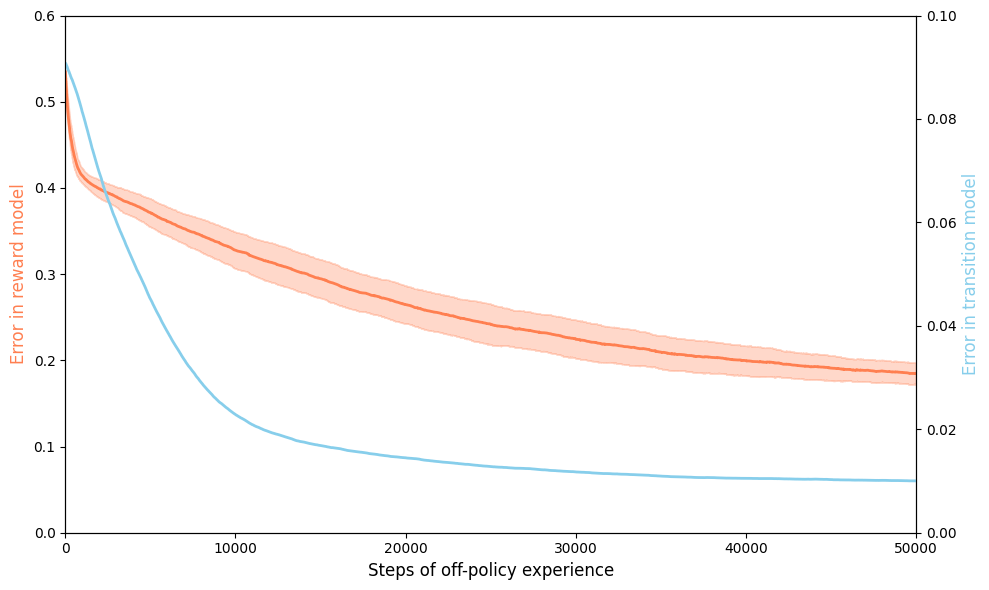

In [7]:
""" Plot the results """

import matplotlib.pyplot as plt

# Calculate the averages
average_error_rmses = np.mean(many_reward_model_rmses, axis=0)
average_transition_error = np.mean(many_transition_model_errors, axis=0)

stddev_error_rmses = np.std(many_reward_model_rmses, axis=0)
stddev_transition_error = np.std(many_transition_model_errors, axis=0)


# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis (left y-axis) for error (red)
ax1.set_xlabel('Steps of off-policy experience', fontsize=12, color='black')
ax1.set_ylabel('Error in reward model', color='coral', fontsize=12)
ax1.plot(range(number_of_steps), average_error_rmses, color='coral', linewidth=2)
ax1.fill_between(
    range(number_of_steps),
    average_error_rmses - stddev_error_rmses,
    average_error_rmses + stddev_error_rmses,
    color='coral',
    alpha=0.3
)
ax1.tick_params(axis='y', labelcolor='coral')
ax1.set_xlim(0, number_of_steps)
ax1.set_ylim(0, 0.6)
ax1.grid(False)

# Secondary axis (right y-axis) for value function (blue)
ax2 = ax1.twinx()
ax2.set_ylabel('Error in transition model', color='skyblue', fontsize=12)
ax2.plot(range(number_of_steps), average_transition_error, color='skyblue', linewidth=2)
# ax2.fill_between(
#     range(number_of_steps),
#     average_error_rmses - stddev_error_rmses,
#     average_error_rmses + stddev_error_rmses,
#     color='skyblue',
#     alpha=0.3
# )
ax2.tick_params(axis='y', labelcolor='skyblue')
ax2.set_ylim(0, .1)
ax2.grid(False)

# Style the plot
for spine in ax1.spines.values():
    spine.set_color('black')
for spine in ax2.spines.values():
    spine.set_color('black')

ax1.tick_params(colors='black')
ax2.tick_params(colors='black')
ax1.xaxis.label.set_color('black')

plt.tight_layout()
plt.show()
